# BVA 529E FINAL ASSESMENT 

### Anıl Ferdi Kaya 090180128

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import RMSprop
import random
from sklearn.preprocessing import StandardScaler
import itertools

In [3]:
data = pd.read_csv("Stocks.csv")

<AxesSubplot:>

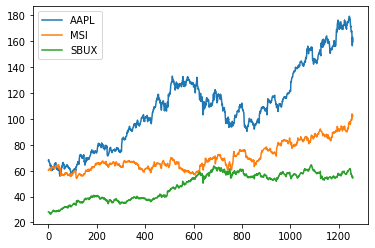

In [4]:
data.plot()

## INITILIZE ENVIRONMENT

In [5]:
class MultiStockEnv:
    """
    A 3-stock trading environment.
    State: vector of size 7 (n_stock * 2 + 1)
        - # shares of stock 1 owned
        - # shares of stock 2 owned
        - # shares of stock 3 owned
        - price of stock 1 (using daily close price)
        - price of stock 2
        - price of stock 3
        - cash owned (can be used to purchase more stocks)
    Action: categorical variable with 27 (3^3) possibilities
        - for each stock, you can:
        - 0 = sell
        - 1 = hold
        - 2 = buy
    """
    def __init__(self, data, initial_investment=20000):
        # data
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

        # instance attributes
        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.action_space = np.arange(3**self.n_stock)

        # action permutations
        # returns a nested list with elements like:
        # [0,0,0]
        # [0,0,1]
        # [0,0,2]
        # [0,1,0]
        # [0,1,1]
        # etc.
        # 0 = sell
        # 1 = hold
        # 2 = buy
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        # calculate size of state
        self.state_dim = self.n_stock * 2 + 1

        self.reset()


    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()


    def step(self, action):
        assert action in self.action_space

        # get current value before performing the action
        prev_val = self._get_val()

        # update price, i.e. go to the next day
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]

        # perform the trade
        self._trade(action)

        # get the new value after taking the action
        cur_val = self._get_val()

        # reward is the increase in porfolio value
        reward = cur_val - prev_val

        # done if we have run out of data
        done = self.cur_step == self.n_step - 1

        # store the current value of the portfolio here
        info = {'cur_val': cur_val}

        # conform to the Gym API
        return self._get_obs(), reward, done, info


    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs
    
    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

    def _trade(self, action):
        # index the action we want to perform
        # 0 = sell
        # 1 = hold
        # 2 = buy
        # e.g. [2,1,0] means:
        # buy first stock
        # hold second stock
        # sell third stock
        action_vec = self.action_list[action]

        # determine which stocks to buy or sell
        sell_index = [] # stores index of stocks we want to sell
        buy_index = [] # stores index of stocks we want to buy
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)

        # sell any stocks we want to sell
        # then buy any stocks we want to buy
        if sell_index:
            # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
        if buy_index:
            # NOTE: when buying, we will loop through each stock we want to buy,
            #       and buy one share at a time until we run out of cash
            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1 # buy one share
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False

In [6]:
action_list = list(map(list, itertools.product([0, 1, 2], repeat=3)))

In [7]:
n_timesteps, n_stocks = data.shape

In [8]:
n_train = n_timesteps // 2
n_train

train_data = data[:n_train].values
test_data = data[n_train:].values

In [9]:
train_data

array([[ 67.8542,  60.3   ,  28.185 ],
       [ 68.5614,  60.9   ,  28.07  ],
       [ 66.8428,  60.83  ,  28.13  ],
       ...,
       [115.4   ,  64.04  ,  59.01  ],
       [115.13  ,  63.8   ,  57.23  ],
       [115.52  ,  64.19  ,  57.2   ]])

In [10]:
env = MultiStockEnv(train_data,initial_investment=20000)

In [11]:
K = len(env.action_list)

## DQN MODEL 

In [12]:
def NNModel(input_shape, K, hidden_layer_sizes,act):
    X_input=Input(input_shape)
    #First Layer
    X = Dense(hidden_layer_sizes[0], input_shape=(env.state_dim,), activation=act, kernel_initializer='he_uniform')(X_input)
    if len(hidden_layer_sizes)>1:
        for M in hidden_layer_sizes[1:]:
            X = Dense(M, activation=act, kernel_initializer='he_uniform')(X)
    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(K, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name='StockExchangeModel')
    model.compile(loss="mse", optimizer=RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])
    model.summary()
    return model

### + STANDART SCALER 

In [13]:
def get_scaler(env):
    # return scikit-learn scaler object to scale the states after fitting the scaler with some random actions
    states = []
    #play game 100 times with random actions to collect some states
    for i in range(100):
        for j in range(env.n_step):
            action = np.random.choice(env.action_space)
            state, reward, done, info = env.step(action)
            states.append(state)
            if done:
                env.reset()
                break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

### GREEDY FUNCTION

In [14]:
def greedy_policy(state,model,epsilon):
    if np.random.rand() <= epsilon:
        return np.random.choice(action_size)
    else:
        return np.argmax(model.predict(state))  # returns action

# RUN CODE 

In [15]:
gamma = 0.95  # discount rate
epsilon = 1.0  # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 200
initial_investment = 20000


n_timesteps, n_stocks = data.shape
n_train = n_timesteps // 2
train_data = data[:n_train].values
test_data = data[n_train:].values

np.random.seed(1)
env = MultiStockEnv(train_data,initial_investment=20000)

#Train the scaler, the scaler only uses the training set
state_size = env.state_dim
action_size = len(env.action_space)
scaler=get_scaler(env)
DQNModel= NNModel(input_shape=(state_size,),K=action_size, act="relu", hidden_layer_sizes=[200,200,200])

#Initialize weights

# store the final value of the portfolio (end of episode)
portfolio_value = []

for i in range(num_episodes):
    done=False
    state = env.reset()
    epsilon=0.97**(i)
    state = scaler.transform([state])
    while not done:
        Q_values = DQNModel.predict(state)
        action = greedy_policy(state,DQNModel,epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if done:
            target = reward
        else:
            nextQ_values = DQNModel.predict(next_state)
            target = reward + gamma * np.max(nextQ_values)
        #Make prediction for all actions first
        target_full = DQNModel.predict(next_state)        #Update target values for only the selected action 
        target_full[0, action] = target
        #Update weights
        DQNModel.fit(state, target_full, batch_size=1, verbose=0)

        
        state=next_state
        
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        
    val=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {val:.2f}")
    portfolio_value.append(val)

2022-06-18 09:07:09.641263: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-18 09:07:09.794111: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "StockExchangeModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 200)               1600      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 27)                5427      
Total params: 87,427
Trainable params: 87,427
Non-trainable params: 0
_________________________________________________________________
episode: 1/200, episode end value: 33036.95
episode: 2/200, episode end value: 37838.36
episode: 3/200, episod

# TEST POLICY

In [16]:
np.random.seed(1)
#Test the performance of the agent with the test data
epsilon = 0.01
env = MultiStockEnv(test_data, initial_investment)
testportfoliovalues=[]
for i in range(num_episodes):
    state = env.reset()
    state = scaler.transform([state])
    done=False
    while not done:
        action = greedy_policy(state,DQNModel,epsilon=epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
    value=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {value:.2f}")
    testportfoliovalues.append(value) # append episode end portfolio value

episode: 1/200, episode end value: 24838.69
episode: 2/200, episode end value: 24444.99
episode: 3/200, episode end value: 22143.87
episode: 4/200, episode end value: 28594.89
episode: 5/200, episode end value: 20610.24
episode: 6/200, episode end value: 26730.14
episode: 7/200, episode end value: 28709.10
episode: 8/200, episode end value: 25068.35
episode: 9/200, episode end value: 21260.21
episode: 10/200, episode end value: 28380.69
episode: 11/200, episode end value: 30009.26
episode: 12/200, episode end value: 28100.31
episode: 13/200, episode end value: 21273.80
episode: 14/200, episode end value: 22171.20
episode: 15/200, episode end value: 20789.84
episode: 16/200, episode end value: 20118.43
episode: 17/200, episode end value: 20409.06
episode: 18/200, episode end value: 32378.73
episode: 19/200, episode end value: 24316.71
episode: 20/200, episode end value: 20330.07
episode: 21/200, episode end value: 25497.52
episode: 22/200, episode end value: 25753.80
episode: 23/200, ep

# RANDOM POLICY

In [17]:
np.random.seed(1)
#How does a random policy do?
epsilon = 1
env = MultiStockEnv(test_data, initial_investment)
randomportfoliovalues=[]
for i in range(num_episodes):
    state = env.reset()
    state = scaler.transform([state])
    done=False
    while not done:
        action = greedy_policy(state,DQNModel,epsilon=epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
    value=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {value:.2f}")
    randomportfoliovalues.append(value) # append episode end portfolio value

episode: 1/200, episode end value: 21172.47
episode: 2/200, episode end value: 30347.43
episode: 3/200, episode end value: 22427.10
episode: 4/200, episode end value: 38796.15
episode: 5/200, episode end value: 38920.86
episode: 6/200, episode end value: 31671.02
episode: 7/200, episode end value: 32637.78
episode: 8/200, episode end value: 23404.49
episode: 9/200, episode end value: 20608.17
episode: 10/200, episode end value: 46674.31
episode: 11/200, episode end value: 21318.84
episode: 12/200, episode end value: 30278.56
episode: 13/200, episode end value: 14336.00
episode: 14/200, episode end value: 29408.74
episode: 15/200, episode end value: 25824.91
episode: 16/200, episode end value: 30745.74
episode: 17/200, episode end value: 27527.49
episode: 18/200, episode end value: 28777.44
episode: 19/200, episode end value: 23216.20
episode: 20/200, episode end value: 32913.26
episode: 21/200, episode end value: 33793.09
episode: 22/200, episode end value: 22321.16
episode: 23/200, ep

In [18]:
TrainingPortfolio=portfolio_value
TestPortfolio=testportfoliovalues
RandomPortfolio=randomportfoliovalues

# SINGLE DQN WITH 200 EPISODES RESULTS

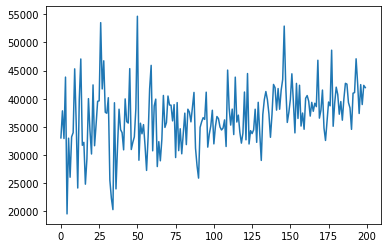

In [19]:
plt.plot(TrainingPortfolio)

(array([ 3.,  6.,  8., 31., 52., 58., 28., 10.,  1.,  3.]),
 array([19537.5002 , 23047.04755, 26556.5949 , 30066.14225, 33575.6896 ,
        37085.23695, 40594.7843 , 44104.33165, 47613.879  , 51123.42635,
        54632.9737 ]),
 <BarContainer object of 10 artists>)

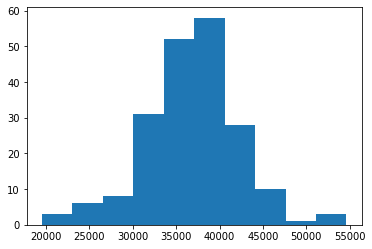

In [20]:
plt.hist(TrainingPortfolio)

In [21]:
np.mean(TrainingPortfolio)

36781.78243800005

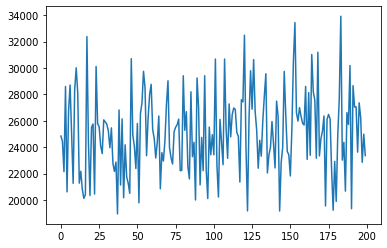

In [22]:
plt.plot(TestPortfolio)

In [23]:
np.mean(TestPortfolio)

25045.30584999997

(array([15., 15., 38., 29., 42., 27., 16., 12.,  3.,  3.]),
 array([18941.07 , 20438.859, 21936.648, 23434.437, 24932.226, 26430.015,
        27927.804, 29425.593, 30923.382, 32421.171, 33918.96 ]),
 <BarContainer object of 10 artists>)

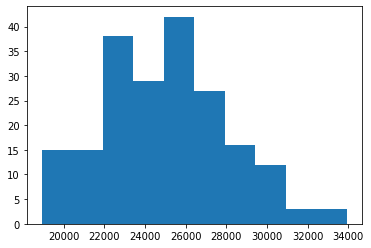

In [24]:
plt.hist(TestPortfolio)

In [25]:
np.mean(RandomPortfolio)

26051.488099999682

(array([ 6., 15., 47., 41., 36., 34., 13.,  5.,  1.,  2.]),
 array([12513.07  , 15929.1935, 19345.317 , 22761.4405, 26177.564 ,
        29593.6875, 33009.811 , 36425.9345, 39842.058 , 43258.1815,
        46674.305 ]),
 <BarContainer object of 10 artists>)

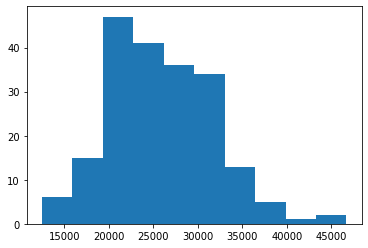

In [26]:
plt.hist(RandomPortfolio)

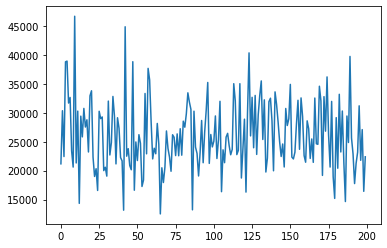

In [27]:
plt.plot(RandomPortfolio)